# This notebook is designed to explore the data

## Imports

In [65]:
# Import dependencies
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import os,sys
import json
import re
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import date, datetime
import dateparser
from pprint import pprint
from itertools import combinations

np.warnings.filterwarnings('ignore')

DATA_DIR = "data"
%matplotlib inline

## Small Helper Functions

In [3]:
def to_date(d):
    return datetime.strptime(d, "%Y-%m-%d").date()

def to_time(t):
    return datetime.strptime(t[:8], "%H:%M:%S").time()

## Load clean data and county data

In [171]:
events = pd.read_csv(os.path.join(DATA_DIR, "Events_USA_2010.tsv"), delimiter="\t")
events = events.where((pd.notnull(events)), None)
county_data = None
with open(os.path.join(DATA_DIR, "county_data.json"), 'r') as _:
    county_data = json.load(_)
    
top_bot_counties = None
with open(os.path.join(DATA_DIR, "top_bottom_counties.json"), 'r') as _:
    top_bot_counties = json.load(_)
    
# Remove counties in state not within our consideration
remove_list = []
for fp, data in county_data.items():
    if fp[:2] in ["43", "00", "72"]:
        remove_list.append(fp)
    if fp[2:] == "000":
        remove_list.append(fp)
for fp in set(remove_list):
    del county_data[fp]

## Plot dates/times of shootings from the clean data

In [5]:
# Collect data on dates and times of shootings
# Prefer Fine Time to Coarse Time if the record has it
event_dates = []
event_times = []
for index, event in events.iterrows():
    event_dates.append(to_date(event["Date"]))
    if event["Fine Time"]:
        event_times.append(to_time(event["Fine Time"]))
    elif event["Coarse Time"]:
        event_times.append(to_time(event["Coarse Time"]))
    else:
        event_times.append(None)

In [6]:
# Create bar charts of # events by year and # events by time of day
num_events_by_year = []
years = range(2010, 2018)
for year in years:
    start = date(year, 1, 1)
    end = date(year, 12,31)
    events_in_year = len([d for d in event_dates if d >= start and d <= end])
    num_events_by_year.append(events_in_year)
    
num_events_by_tod = []
time_ranges = [(0, 6), (6, 12), (12, 18), (18, 0)]
for tr in time_ranges:
    start = datetime.now().replace(hour=tr[0], minute=0, second=0, microsecond=0).time()
    end = datetime.now().replace(hour=(tr[1]-1) % 24, minute=59, second=59, microsecond=0).time()
    events_in_time_range = len([t for t in event_times if t and t >= start and t <= end])
    num_events_by_tod.append(events_in_time_range)
    
num_empty_times = len([t for t in event_times if not t])

print("%d total events" % len(event_times))
print("%d events with no time" % num_empty_times)

2966 total events
638 events with no time


Text(0,0.5,'Number of Gun Violence Events')

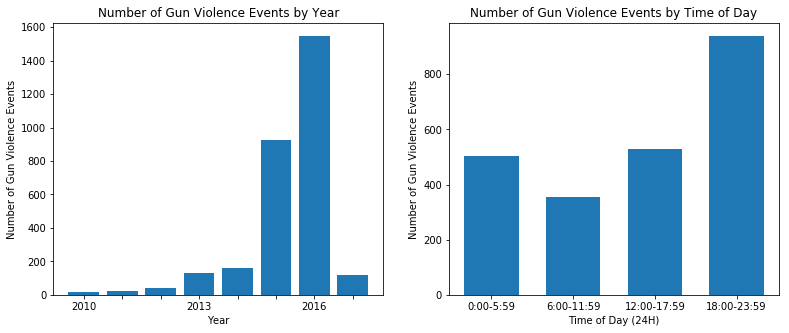

In [7]:
# Show the graphs
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].bar(years, num_events_by_year, tick_label=[str(year) if i % 3 == 0 else "" for i, year in enumerate(years)])
ax[0].set_title("Number of Gun Violence Events by Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Gun Violence Events")

ax[1].bar([tr[0] for tr in time_ranges], num_events_by_tod, width=4,
        tick_label=["0:00-5:59", "6:00-11:59", "12:00-17:59", "18:00-23:59"])
ax[1].set_title("Number of Gun Violence Events by Time of Day")
ax[1].set_xlabel("Time of Day (24H)")
ax[1].set_ylabel("Number of Gun Violence Events")

The first graph indicates that our data is very heavily biased towards more recent events, and specifically 2016. No other data source cites a climb in gun violence of 800% from 2014 to 2016, so this bias is likely from more recent reports being available, or the data collection process.

The second graph indicates that between 6PM and midnight is the most likely time for gun violence to occur. It is roughly twice as likely in that time range than in any other.

## Determine how many counties are represented in our data
There are 3007 counties in the United States

In [8]:
counties = {}
for index, event in events.iterrows():
    state = event["StateFP"]
    county = event["CountyFP"]
    if state not in counties:
        counties[state] = {}
    counties[state][county] = counties[state].get(county, 0) + 1
num_counties = sum([len(c) for i,c in counties.items()])
print("Gun violence events in %d counties" % num_counties)
print("Data available on %d counties" % len(county_data))

Gun violence events in 877 counties
Data available on 3154 counties


## Calculate statistics for all counties
Population Density, Education, Unemployment, Poverty 

In [9]:
def get_stats(data, title):
    _mean = np.mean(data)
    _median = np.median(data)
    _min = np.min(data)
    _max = np.max(data)
    print()
    print(title)
    print("Min: %f | Max: %f | Mean: %f | Median: %f" % (_min, _max, _mean, _median))
    return (_min, _max, _mean, _median)

In [10]:
_pop_density = []
_edu = []
_unemp = []
_poverty = []

failcount = 0
for fp, data in county_data.items():
    try:
        pop = int(np.mean([int(data["pop"][str(y)]) for y in range(2010, 2018)]))
        # Mean unemployment from 2010 to 2017
        unemp = np.mean([data["unemp"][str(y)] for y in range(2010, 2018)])
        _unemp.append(unemp)
        pop_density = data["pop_density"]
        _pop_density.append(pop_density)
        edu = data["edu"]
        _edu.append(edu)
        poverty = data["poverty"]
        _poverty.append(poverty)
    except:
        failcount += 1
        
print("Failed: %d" % failcount)

_pop_density_stats = get_stats(_pop_density, "Population Density")
_edu_status = get_stats(_edu, "Education")
_unemp_stats = get_stats(_unemp, "Unemployment")
_poverty_stats = get_stats(_poverty, "Poverty")

Failed: 15

Population Density
Min: 0.038516 | Max: 71276.960140 | Mean: 266.655161 | Median: 45.010312

Education
Min: 48.500000 | Max: 98.700000 | Mean: 85.814591 | Median: 87.300000

Unemployment
Min: 1.800000 | Max: 25.112500 | Mean: 6.873551 | Median: 6.762500

Poverty
Min: 0.033819 | Max: 0.485278 | Mean: 0.152449 | Median: 0.143878


## Verify that we have data representation for all counties

In [11]:
event_counties = {}
for index, row in events.iterrows():
    state_fp = str(row["StateFP"])
    county_fp = str(row["CountyFP"])
    state_fp = "0"*(2-len(state_fp)) + state_fp
    county_fp = "0"*(3-len(county_fp)) + county_fp
    fp = state_fp + county_fp
    event_counties[fp] = event_counties.get(fp, 0) + 1

lack_data = 0
for fp, count in event_counties.items():
    data = county_data[fp]
    if len(data) < 5:
        lack_data += 1

if lack_data == 0:
    print("Data available for all counties!")
else:
    print("Missing some data for %d counties!" % lack_data)

Data available for all counties!


## Calculate statistics for counties in our data set
Population Density, Education, Unemployment, Poverty 

In [12]:
_pop_density = []
_edu = []
_unemp = []
_poverty = []

failcount = 0
for fp, data in county_data.items():
    if fp in event_counties:
        try:
            pop = int(np.mean([int(data["pop"][str(y)]) for y in range(2010, 2018)]))
            # Mean unemployment from 2010 to 2017
            unemp = np.mean([data["unemp"][str(y)] for y in range(2010, 2018)])
            _unemp.append(unemp)
            pop_density = data["pop_density"]
            _pop_density.append(pop_density)
            edu = data["edu"]
            _edu.append(edu)
            poverty = data["poverty"]
            _poverty.append(poverty)
        except:
            failcount += 1
        
print("Failed: %d" % failcount)

_pop_density_stats = get_stats(_pop_density, "Population Density")
_edu_status = get_stats(_edu, "Education")
_unemp_stats = get_stats(_unemp, "Unemployment")
_poverty_stats = get_stats(_poverty, "Poverty")

Failed: 0

Population Density
Min: 0.038516 | Max: 71276.960140 | Mean: 724.039533 | Median: 158.431224

Education
Min: 48.500000 | Max: 97.900000 | Mean: 86.888826 | Median: 88.000000

Unemployment
Min: 2.675000 | Max: 22.387500 | Mean: 6.989438 | Median: 6.825000

Poverty
Min: 0.033819 | Max: 0.401823 | Mean: 0.145605 | Median: 0.141190


## Determine statistics on number of events per county

In [13]:
count_list = []
for fp, count in event_counties.items():
    count_list.append(count)

mean_count = int(np.mean(count_list))
median_count = int(np.median(count_list))
min_count = int(np.min(count_list))
max_count = int(np.max(count_list))
print("Number of Events per County")
print("Min: %d | Max: %d | Mean: %d | Median: %d" % (min_count, max_count, mean_count, median_count))

Number of Events per County
Min: 1 | Max: 138 | Mean: 3 | Median: 1


## Determine statistics on ratio of events/population density per county

In [14]:
event_densities = []
for fp, count in event_counties.items():
    pop_density = county_data[fp]["pop_density"]
    event_density = count/pop_density
    event_densities.append(event_density)

mean_density = np.mean(event_densities)
median_density = np.median(event_densities)
min_density = np.min(event_densities)
max_density = np.max(event_densities)
print("Number of Events/Population Density per County")
print("Min: %.4f | Max: %.4f | Mean: %0.4f | Median: %0.4f" % (min_density, max_density, mean_density, median_density))

Number of Events/Population Density per County
Min: 0.0002 | Max: 29.3267 | Mean: 0.0946 | Median: 0.0110


## Sort counties into positive/negative based on events/population density

In [15]:
pos_events = []
neg_events = []
pos_X = {}
neg_X = {}
feature_labels = ["Population Density", "Education", "Unemployment", "Poverty"]
for fp, count in event_counties.items():
    data = county_data[fp]
    # Mean population from 2010 to 2017
    pop = int(np.mean([int(data["pop"][str(y)]) for y in range(2010, 2018)]))
    # Mean unemployment from 2010 to 2017
    unemp = np.mean([data["unemp"][str(y)] for y in range(2010, 2018)])
    land = data["land"]
    pop_density = data["pop_density"]
    edu = data["edu"]
    poverty = data["poverty"]
    
    event_density = count/pop_density
    X_data = [pop_density, edu, unemp, poverty]
    
    if event_density <= 0.011:
        neg_events.append(fp)
        neg_X[fp] = X_data
    else:
        pos_events.append(fp)
        pos_X[fp] = X_data
        
print("Number of Positive Events: %d" % len(pos_events))
print("Number of Negative Events: %d" % len(neg_events))

Number of Positive Events: 438
Number of Negative Events: 439


## Prepare data for feature analysis

In [16]:
data_X = []
data_Y = []
data_fips = []
for fp, data in pos_X.items():
    data_X.append(data)
    data_Y.append(1)
    data_fips.append(fp)
    
for fp, data in neg_X.items():
    data_X.append(data)
    data_Y.append(0)
    data_fips.append(fp)
    
r_index = np.arange(len(data_X))
np.random.shuffle(r_index)
data_X = np.array(data_X)[r_index]
data_Y = np.array(data_Y)[r_index]
data_fips = np.array(data_fips)[r_index]

#data_X = normalize(data_X, norm='l2', axis=1)

## Plot by combinations of features

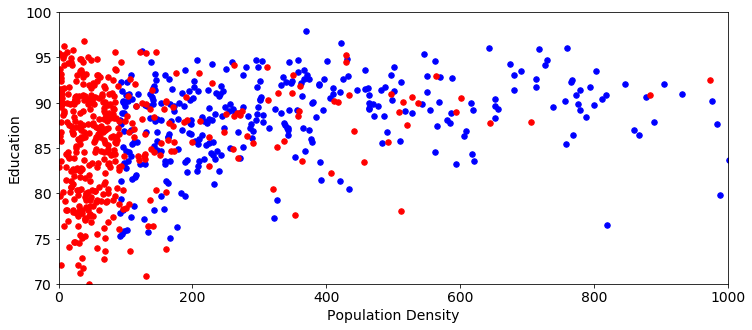

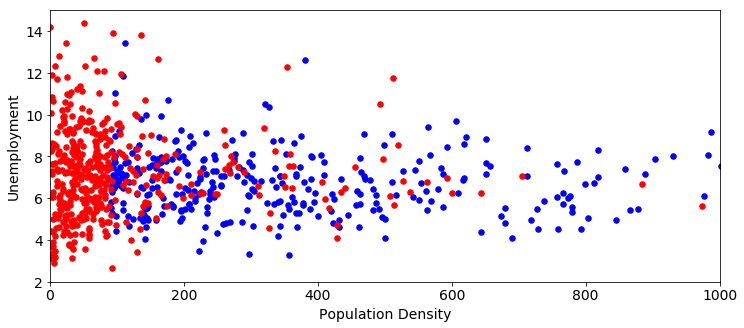

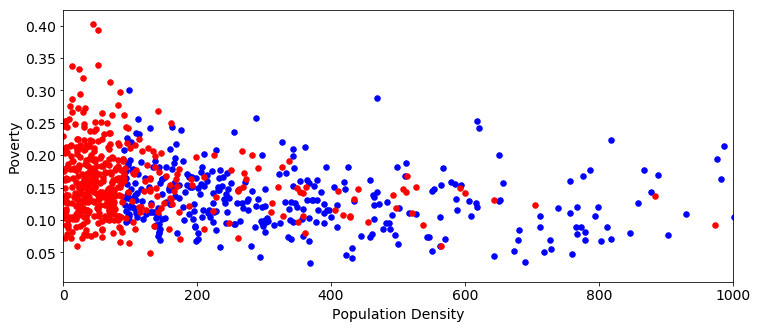

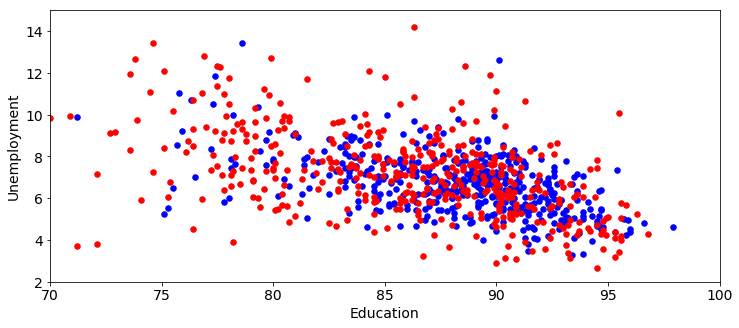

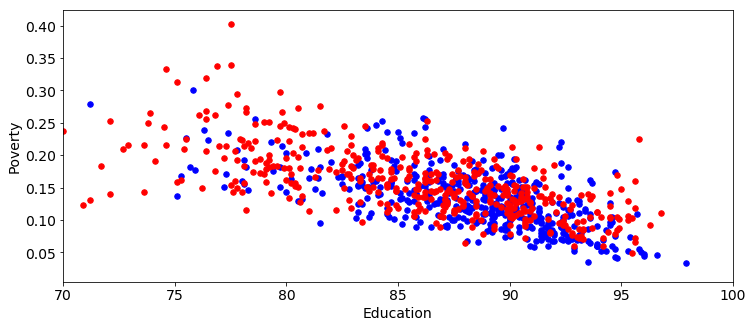

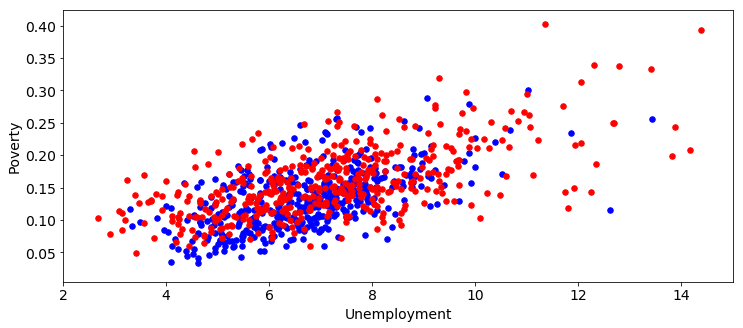

In [172]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

feature_combs = list(combinations(range(data_X.shape[1]), 2))
for comb in feature_combs:
    fx_i = comb[0]
    fx_label = feature_labels[fx_i]
    fy_i = comb[1]
    fy_label = feature_labels[fy_i]
    
    plot_X = data_X[:, (fx_i, fy_i)]
    
    fig = plt.figure(figsize=(12,5))
    for i, c, label in zip([0, 1], ['b', 'r'], ['Low Incidence', 'High Incidence']):
        plt.scatter(data_X[data_Y == i, fx_i], data_X[data_Y == i, fy_i], c=c, label=label, s=30)
    plt.xlabel(fx_label)
    plt.ylabel(fy_label)
    
    # Population Density
    if fx_i == 0:
        plt.xlim([0, 1000])
    if fy_i == 0:
        plt.ylim([0, 1000]) 
    
    # Education
    if fx_i == 1:
        plt.xlim([70, 100])
    if fy_i == 1:
        plt.ylim([70, 100])
        
    # Unemployment
    if fx_i == 2:
        plt.xlim([2, 15])
    if fy_i == 2:
        plt.ylim([2, 15])
    
    #kmeans = KMeans(init='random', n_clusters=2)
    #kmeans.fit(data_X)
    
    #clusters = kmeans.predict

## 3-Feature Plot
Education, Unemployment, Poverty

/Users/evan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


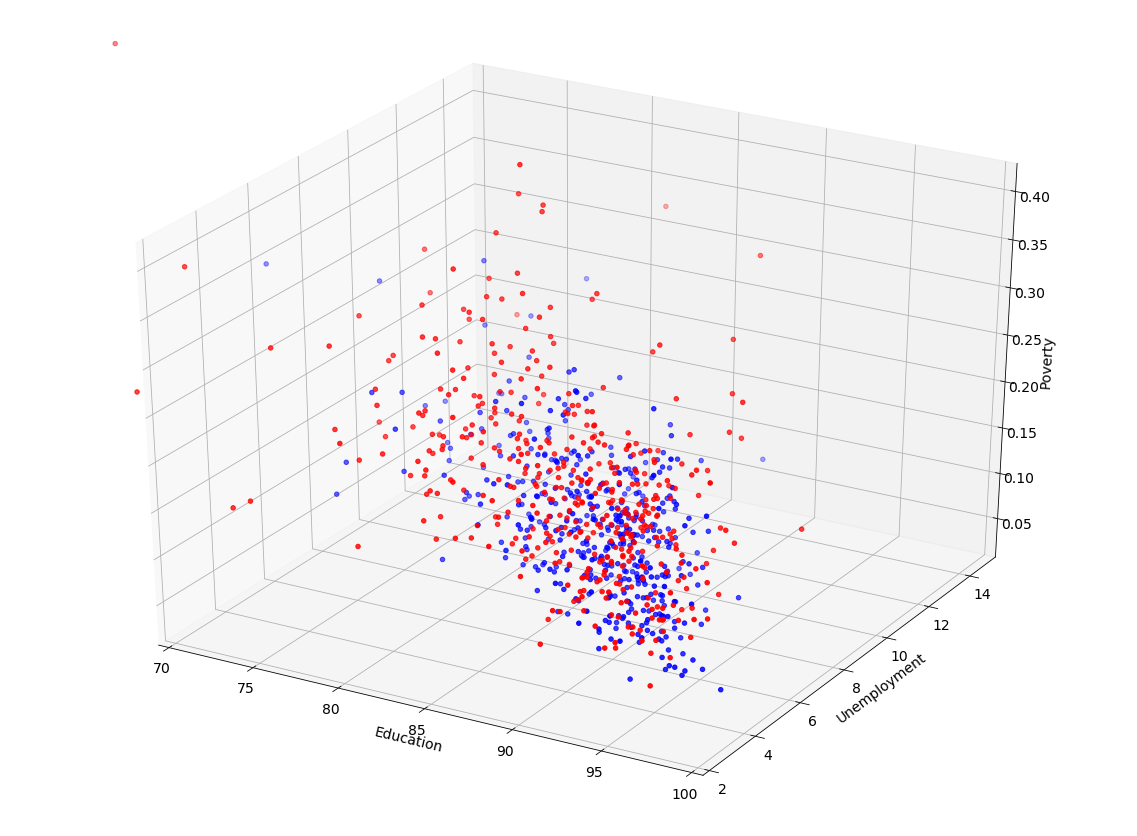

In [18]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(feature_labels[1])
ax.set_ylabel(feature_labels[2])
ax.set_zlabel(feature_labels[3])

ax.set_xlim([70, 100])
ax.set_ylim([2, 15])
    
for i, c, label in zip([0, 1], ['b', 'r'], ['Low Incidence', 'High Incidence']):
        plt.scatter(data_X[data_Y == i, 1], data_X[data_Y == i, 2], s=20, zs=data_X[data_Y == i, 3],
                    c=c, label=label)

## Use Linear Regression, Logistic Regression, and Random Forest
Not using Population Density as a feature since it was involved in deciding negative/positive

### Run multiple trials of cross-validation and average scores

In [19]:
def run_trials(model, dX, dY, trials=10):
    scores = []
    for i in range(trials):
        kf = KFold(n_splits=5, shuffle=True)
        for train, test in kf.split(dX):
            train_X = dX[train]
            test_X = dX[test]
            train_Y = dY[train]
            test_Y = dY[test]

            model.fit(train_X[:,1:], train_Y)
            score = model.score(test_X[:,1:], test_Y)
            scores.append(score)
            
    avg_score = np.mean(scores)
    return avg_score

### Score with multiple models via voting

In [118]:
def run_multimodel_trials(estimators, dX, dY, trials=10):
    scores = []
    for i in range(trials):
        kf = KFold(n_splits=5, shuffle=True)
        for train, test in kf.split(dX):
            train_X = dX[train]
            test_X = dX[test]
            train_Y = dY[train]
            test_Y = dY[test]
            vc = VotingClassifier(estimators, voting="hard")
            vc.fit(train_X[:,1:], train_Y)
            score = vc.score(test_X[:,1:], test_Y)
            scores.append(score)
            
    avg_score = np.mean(scores)
    return avg_score

### Show Hyperparameter Changes

In [166]:
def show_hyperparameter_changes(scores, param_label, model_label, rotation=0, limit_yticks=False):
    scores = np.array(scores)
    h_Y = scores[:, 0]
    h_X = scores[:, 1]
    fig = plt.figure()
    plt.plot(h_X, h_Y)
    plt.title("%s: Scores vs %s" % (model_label, param_label))
    plt.xlabel(param_label)
    plt.ylabel("Score")
    plt.xticks(rotation=rotation)
    
    if limit_yticks:
        locs, labels = plt.yticks()
        new_locs = [loc for i, loc in enumerate(locs) if i % 5 == 0]
        new_labels = ["{:.3f}".format(float(score)) for score in h_Y[new_locs]]
        plt.yticks(new_locs, new_labels)

### Linear Regression

In [21]:
linreg = LinearRegression()
avg_linreg_score = run_trials(linreg, data_X, data_Y)
print("Average Linear Regression Score: %f" % avg_linreg_score)

Average Linear Regression Score: 0.054968


### Logistic Regression

In [22]:
logreg = LogisticRegression()
avg_logreg_score = run_trials(logreg, data_X, data_Y)
print("Average Logistic Regression Score: %f" % avg_logreg_score)

Average Logistic Regression Score: 0.599551


### KNN Classifier w/ Hyperparameter Optimization

Best KNN Classifier: Score=0.595802 | n_estimators=28


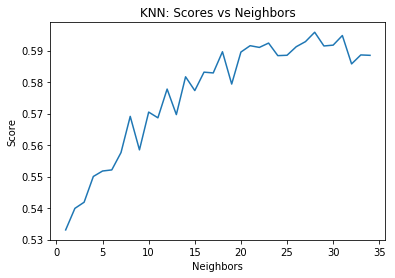

In [74]:
knn_scores = []
for n_neighbors in range(1, 35):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    avg_knn_score = run_trials(knn, data_X, data_Y)
    knn_scores.append([avg_knn_score, n_neighbors])
    #print("KNN Score (n_neighbors=%d): %f" % (n_neighbors, avg_knn_score))

show_hyperparameter_changes(knn_scores, "# Neighbors", "KNN")

knn_scores.sort(key=lambda x: x[0], reverse=True)
best_knn = knn_scores[0]
best_knn_score = best_knn[0]
best_n_neighbors = best_knn[1]

print("Best KNN Classifier: Score=%f | n_estimators=%d" % (best_knn_score, best_n_neighbors))

### Random Forest Classifier w/ Hyperparameter Optimization

Best Random Forest Model: Score=0.597476 | n_estimators=15


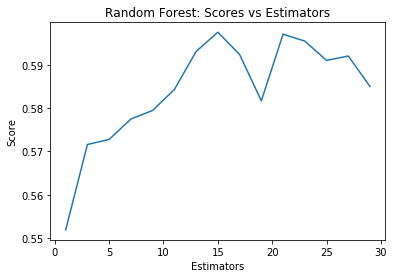

In [75]:
ranfor_scores = []
for n_estimators in range(1, 30, 2):
    ranfor = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    avg_ranfor_score = run_trials(ranfor, data_X, data_Y)
    ranfor_scores.append([avg_ranfor_score, n_estimators])
    #print("Random Forest Score (n_estimators=%d): %f" % (n_estimators, avg_ranfor_score))
    
show_hyperparameter_changes(ranfor_scores, "# Estimators", "Random Forest")

ranfor_scores.sort(key=lambda x: x[0], reverse=True)
best_ranfor = ranfor_scores[0]
best_ranfor_score = best_ranfor[0]
best_n_estimators = best_ranfor[1]

print("Best Random Forest Model: Score=%f | n_estimators=%d" % (best_ranfor_score, best_n_estimators))

### Gaussian Naive Bayes

In [108]:
gaussian_nb = GaussianNB()
avg_gauss_nb_score = run_trials(gaussian_nb, data_X, data_Y)
print("Average Gaussian Naive Bayes Score: %f" % avg_gauss_nb_score)

Average Gaussian Naive Bayes Score: 0.621237


### Multinomial Naive Bayes

In [111]:
multi_nb = MultinomialNB()
avg_multi_nb_score = run_trials(multi_nb, data_X, data_Y)
print("Average Multinomial Naive Bayes Score: %f" % avg_multi_nb_score)

Average Multinomial Naive Bayes Score: 0.581753


### Max Vote among Logistic Regression, KNN, Random Forest, Gaussian Naive Bayes, Multinomial Naive Bayes
15 Estimators for Random Forest and 28 Neighbors for KNN based on hyperparameter optimization

Best Average Max Vote Score: 0.613108 | Estimators: RF, GNB


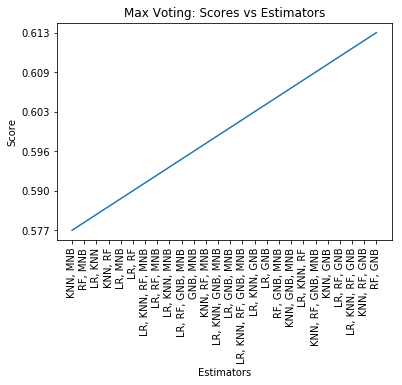

In [170]:
logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=28, n_jobs=-1)
ranfor = RandomForestClassifier(n_estimators=15, n_jobs=-1)
gaussian_nb = GaussianNB()
multi_nb = MultinomialNB()

estimators = np.array([("LR", logreg), ("KNN", knn), ("RF", ranfor), ("GNB", gaussian_nb), ("MNB", multi_nb)])

est_sets = []
for i in range(len(estimators)-1):
    est_sets += list(combinations(estimators, i+2))

est_set_scores = []
for est_set in est_sets:
    avg_vote_score = run_multimodel_trials(est_set, data_X, data_Y)
    est_set_labels = ", ".join([est[0] for est in est_set])
    est_set_scores.append([avg_vote_score, est_set_labels])
    #print("Average Max Vote Score: %f | Estimators:" % avg_vote_score, est_set_labels)

est_set_scores.sort(key=lambda x: x[0], reverse=True)
best_est_set = est_set_scores[0]
best_est_set_score = best_est_set[0]
best_est_comb = best_est_set[1]

show_hyperparameter_changes(sorted(est_set_scores, key=lambda x: x[0]), "Estimators", "Max Voting",
                            rotation=90, limit_yticks=True)

print("Best Average Max Vote Score: %f | Estimators:" % best_est_set_score, best_est_comb)